### Decision Making with Data Science

In [1]:
!pip install seaborn==0.11.0 lightgbm shap

     |████████████████████████████████| 283 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 326 kB 66.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 63.8 MB/s eta 0:00:01
     |████████████████████████████████| 24.6 MB 54.0 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=522638 sha256=e224c16074ab8fb5deda8a4e8cf0da353fbf6bcf02a83fb59ae235285209a4d1
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built shap
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


In [2]:
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold,RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the default style as Seaborn
sns.set()
sns.set_palette("Spectral")
sns.set_style('ticks',
              {
                  'axes.facecolor': 'white',
                  'axes.spines.left': True,
                  'axes.spines.bottom': True,
                  'axes.spines.right':False,
                  'axes.spines.top': False
              }
             )

In [4]:
# Display the Current style
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False}

In [5]:
# Initialise Shap
shap.initjs()

***
#### Dataset Columns Definition
***
|Variable (Abbr.) |Unit|
|---|---|
|Ambient temperature (AT)| C |
|Ambient pressure (AP)| mbar|
|Ambient humidity (AH)| (%)|
|Air filter difference pressure (AFDP) |mbar|
|Gas turbine exhaust pressure (GTEP)| mbar |
|Turbine inlet temperature (TIT)| C|
|Turbine after temperature (TAT)| C |
|Compressor discharge pressure (CDP)| mbar|
|Turbine energy yield (TEY)| MWH|
|Carbon monoxide (CO)| mg/m3|
|Nitrogen oxides (NOx)| mg/m3|

In [6]:
"Insert the credentials here to include the Dataset"

In [7]:
# Display the first few rows, defaults to 5
df.head()

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
0  2011  4.5878  1018.7     NaN     NaN  23.979  1086.2  549.83  134.67   
1  2011  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67   
2  2011  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10   
3  2011     NaN     NaN  85.434  3.5808  23.911  1086.5  550.17  135.03   
4  2011  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67   

      CDP       CO     NOX  
0  11.898  0.32663  81.952  
1  11.892  0.44784  82.377  
2  12.042  0.45144  83.776  
3  11.990  0.23107  82.505  
4  11.910  0.26747  82.028

In [8]:
# Display the shape to identify the number of instances as well as the features
print("The Shape of the dataset is {} with {} rows and {} columns".format(df.shape,df.shape[0],df.shape[1]))

The Shape of the dataset is (36733, 12) with 36733 rows and 12 columns


In [9]:
# Display the last few rows, defaults to 5
df.tail()

YEAR      AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
36728  2015  3.6268  1028.5  93.200  3.1661  19.087  1037.0  541.59  109.08   
36729  2015  4.1674  1028.6  94.036  3.1923  19.016  1037.6  542.28  108.79   
36730  2015  5.4820  1028.5  95.219  3.3128  18.857  1038.0  543.48  107.81   
36731  2015  5.8837  1028.7  94.200  3.9831  23.563  1076.9  550.11  131.41   
36732  2015  6.0392  1028.8  94.547  3.8752  22.524  1067.9  548.23  125.41   

          CDP       CO      NOX  
36728  10.411  10.9930   89.172  
36729  10.344  11.1440   88.849  
36730  10.462  11.4140   96.147  
36731  11.771   3.3134   64.738  
36732  11.462  11.9810  109.240

In [10]:
# Drop the NOx Column since we will be focusing only on CO Emission
df.drop(columns=['NOX'],inplace=True)

In [11]:
# Understanding the type of values present within every column
df.dtypes

YEAR      int64
AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
dtype: object

In [12]:
# Display various Statistics of the Data like Mean, Std etc. except the year
df.iloc[:,1:].describe()

AT            AP            AH          AFDP          GTEP  \
count  36732.000000  36732.000000  36732.000000  36731.000000  36733.000000   
mean      17.713107   1013.070023     77.866857      3.925502     25.563801   
std        7.447196      6.463376     14.461520      0.773939      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781750   1008.800000     68.187750      3.355600     23.129000   
50%       17.801000   1012.600000     80.468500      3.937700     25.104000   
75%       23.665500   1017.000000     89.376000      4.376850     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  
count  36732.000000  36731.000000  36733.000000  36732.000000  36733.000000  
mean    1081.428038    546.158771    133.506404     12.060528      2.372468  
std       17.536609      6.842159     15.618634      1.088810      2.262672  
min     1000.800000    511.040000    100.020000      9.851800      0.000388  
25%     1071.800000    544.720000    124.450000     11.434750      1.182400  
50%     1085.900000    549.880000    133.730000     11.965000      1.713500  
75%     1097.000000    550.040000    144.080000     12.855250      2.842900  
max     1100.900000    550.610000    179.500000     15.159000     44.103000

***
#### Write your findings here.
***

In [13]:
# Is our data complete? do we have mission values in it?
df.isna().head()

YEAR     AT     AP     AH   AFDP   GTEP    TIT    TAT    TEY    CDP     CO
0  False  False  False   True   True  False  False  False  False  False  False
1  False  False  False  False  False  False  False  False  False  False  False
2  False  False  False  False  False  False  False  False  False  False  False
3  False   True   True  False  False  False  False  False  False  False  False
4  False  False  False  False  False  False  False  False  False  False  False

In [14]:
# How many columns have missing values?
df.isna().any(axis=0)

YEAR    False
AT       True
AP       True
AH       True
AFDP     True
GTEP    False
TIT      True
TAT      True
TEY     False
CDP      True
CO      False
dtype: bool

In [15]:
# How many missing values NAN per column are there?
df.isna().sum()

YEAR    0
AT      1
AP      1
AH      1
AFDP    2
GTEP    0
TIT     1
TAT     2
TEY     0
CDP     1
CO      0
dtype: int64

In [16]:
# What are the total number of entries that are NAN
df.isna().sum().sum()

9

In [17]:
# How many rows have atleast one column with an NAN Value
df[df.isna().any(axis=1)].shape

(7, 11)

In [18]:
# Display the rows with NAN values
df[df.isna().any(axis=1)]

YEAR       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
0    2011   4.5878  1018.7     NaN     NaN  23.979  1086.2  549.83  134.67   
3    2011      NaN     NaN  85.434  3.5808  23.911  1086.5  550.17  135.03   
9    2011   4.8281  1018.5  85.346  3.5158  23.422     NaN  549.80  132.67   
81   2011   7.3157  1019.9  79.696  3.5724  23.556  1085.0  549.77  134.49   
297  2011  13.3150  1014.8  82.106     NaN  32.067  1100.2  531.40  158.35   
442  2011  13.9490  1013.2  90.775  4.9160  31.727  1100.0     NaN  156.70   
445  2011  14.7780  1012.8  86.911  3.9239  24.308  1086.3     NaN  133.54   

        CDP       CO  
0    11.898  0.32663  
3    11.990  0.23107  
9    11.694  1.02810  
81      NaN  1.18700  
297  13.866  0.43963  
442  13.731  0.39632  
445  11.953  1.09920

In [19]:
# What percentage of  data contains NAN
print("{:.4f}% rows contain some columns with NAN values in them.\nDropping rows will result in removal of {} entries "\
      "from the dataset".
      format(np.divide(df[df.isna().any(axis=1)].shape[0],df.shape[0]),df[df.isna().any(axis=1)].shape[0]))

0.0002% rows contain some columns with NAN values in them.
Dropping rows will result in removal of 7 entries from the dataset


In [20]:
# Drop all the rows which have the NAN values
df = df.dropna()

In [21]:
# Check how many rows still have NAN Values
df.isna().sum().sum()

0

In [22]:
# Display the current shape of data
print("The Shape of the dataset after removing NAN values "\
      "is {} with {} rows and {} columns".
      format(df.shape,df.shape[0],df.shape[1]))

The Shape of the dataset after removing NAN values is (36726, 11) with 36726 rows and 11 columns


***
#### What difference will the outliers make?
***

In [23]:
# For plotting change the scale of the Columns by a factor of 10 where needed
df['AP'] = df['AP'].apply(lambda x : np.divide(x,100))
df['AH'] = df['AH'].apply(lambda x : np.divide(x,10))
df['TIT'] = df['TIT'].apply(lambda x : np.divide(x,100))
df['TAT'] = df['TAT'].apply(lambda x : np.divide(x,100))
df['TEY'] = df['TEY'].apply(lambda x : np.divide(x,10))

In [24]:
# Get the list of Columns 
column_list = df.columns
print(column_list)

Index(['YEAR', 'AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP',
       'CO'],
      dtype='object')


In [27]:
# Column Information
column_info = {
    "AT" : "Ambient temperature in C",
    "AP" : "Ambient pressure in mbar",
    "AH" : "Ambient humidity in %",
    "AFDP" : "Air filter difference pressure in mbar",
    "GTEP" : "Gas turbine exhaust pressure in mbar",
    "TIT" : "Turbine inlet temperature in C",
    "TAT" : "Turbine after temperature in C",
    "CDP" : "Compressor discharge pressure in mbar",
    "TEY" : "Turbine energy yield in MWH"
}

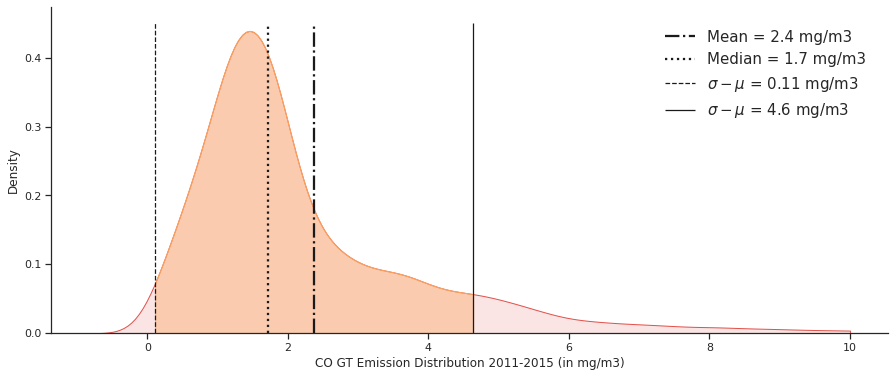

In [28]:
# Plot the Distribution of the Target column CO
fig, axes = plt.subplots(figsize=(15,6))
x = df['CO']
mean = x.mean()
median = x.median()
std = x.std()
left = mean - std
right = mean + std

sns.kdeplot(ax=axes, x=x, shade="fill",
            clip=(-1,10), alpha=0.15, linewidth=1)
sns.kdeplot(ax=axes, x=x, shade="fill",
            clip=(left,right), alpha=0.4, linewidth=1)
height = axes.get_ylim()[1] - 0.01

axes.vlines([mean], 0, height,
                   ls='-.', linewidth=2.25, label=r'Mean = {:.2} mg/m3'.format(mean))
axes.vlines([median], 0, height, 
                   ls=':', linewidth=2.25, label=r'Median = {:.2} mg/m3'.format(median))
axes.vlines([left], 0, height,
                   ls='--', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(left))
axes.vlines([right], 0, height, 
                   ls='-', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(right))
axes.legend(loc="best", fontsize = 15, facecolor='white', edgecolor='white', borderpad = 1) 
plt.xlabel("CO GT Emission Distribution 2011-2015 (in mg/m3)")   
plt.show()  

***
#### Write your findings here.
***

In [29]:
# Plot the Distribution of the Target column CO by the Year
fig, axes = plt.subplots(5, figsize=(12,20),sharey = True, sharex = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) Distribution 2011-2015')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year]['CO']    
    mean = x.mean()
    median = x.median()
    std = x.std()
    left = mean - std
    right = mean + std
    
    sns.kdeplot(ax=axes[index], x=x, shade="fill",
                clip=(-1,10,right), alpha=0.15, linewidth=1)
    sns.kdeplot(ax=axes[index], x=x, shade="fill",
                clip=(left,right), alpha=0.4, linewidth=1)
    height = axes[index].get_ylim()[1] - 0.01
        
    axes[index].vlines([mean], 0, height,
                       ls='-.', linewidth=2.25, label=r'Mean = {:.2} mg/m3'.format(mean))
    axes[index].vlines([median], 0, height, 
                       ls=':', linewidth=2.25, label=r'Median = {:.2} mg/m3'.format(median))
    axes[index].vlines([left], 0, height, 
                       ls='--', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(left))
    axes[index].vlines([right], 0, height, 
                       ls='-', linewidth=1.25, label=r'$\sigma - \mu$ = {:.2} mg/m3'.format(right))

    
    axes[index].text(-1,0.55,str(year),bbox={'facecolor': 'white', 'alpha': 0, 'pad': 7}, fontsize=16)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    
plt.xlabel("CO Emission (in mg/m3)")   
plt.show()

***
#### Write your findings here.
***

In [31]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[1]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[1],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [32]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[2]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[2],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [33]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[3]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[3],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

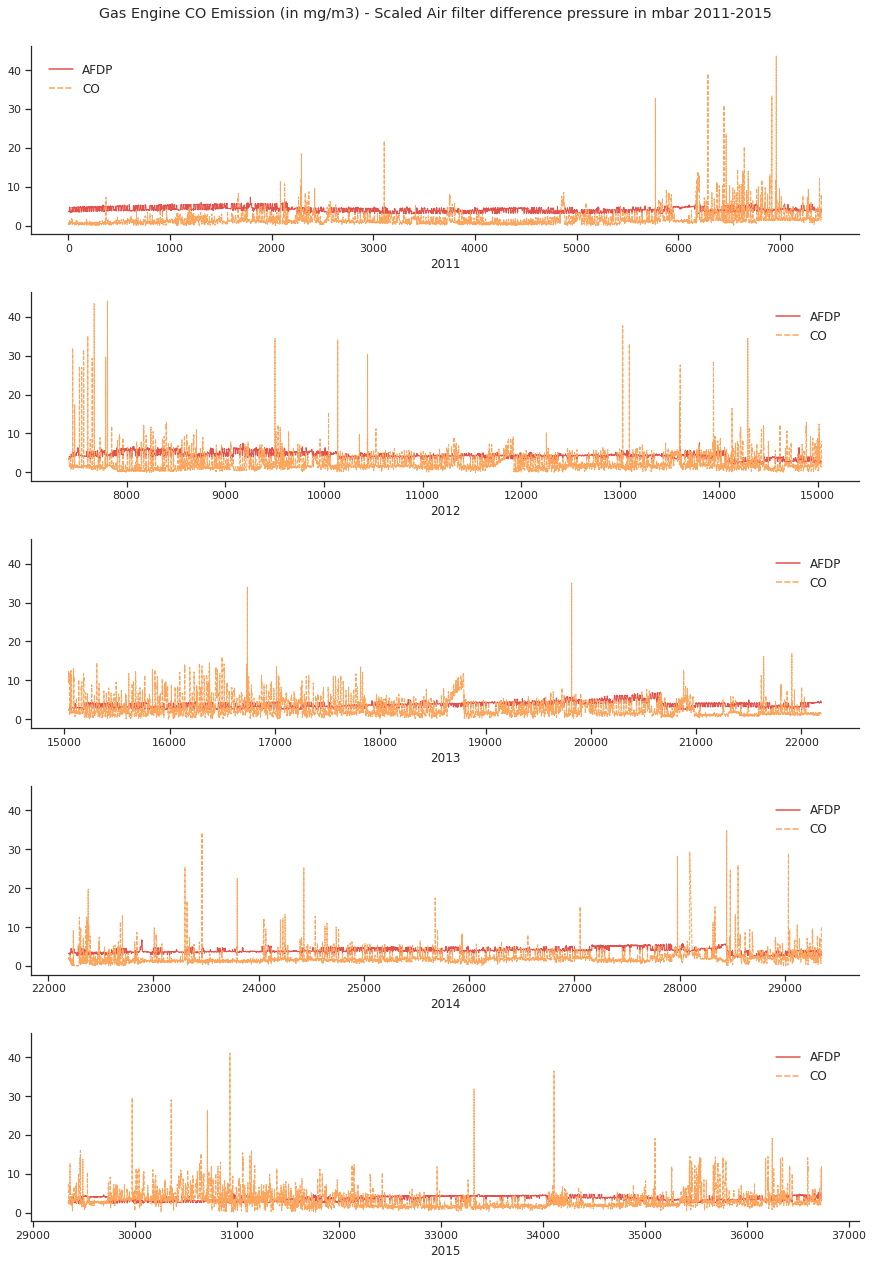

In [34]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[4]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[4],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

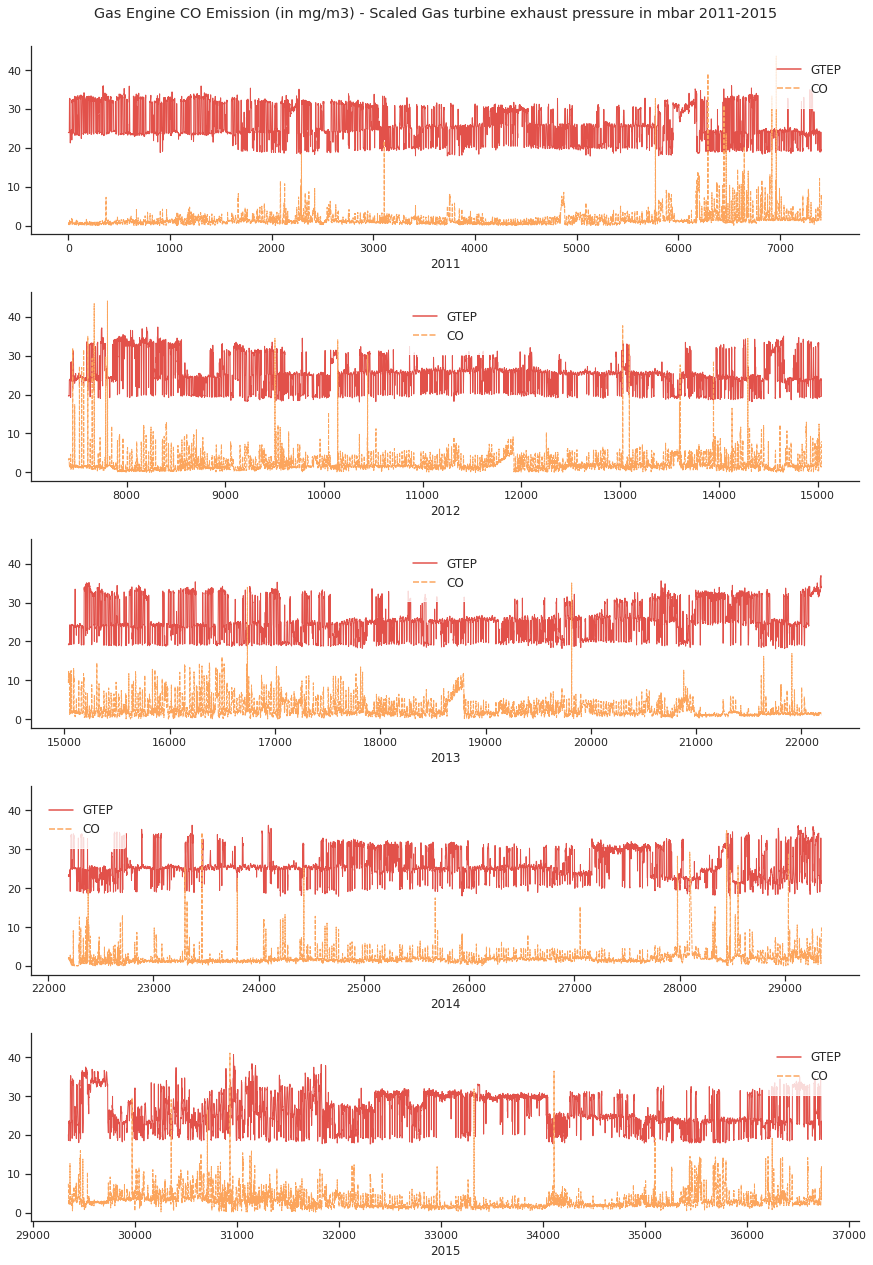

In [35]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[5]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[5],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [36]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[6]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[6],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [37]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[7]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[7],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [38]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[8]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[8],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [39]:
# Plot the Target column and the Feature indexed by time
fig, axes = plt.subplots(5, figsize=(13,18),sharey = True)
fig.suptitle('Gas Engine CO Emission (in mg/m3) - Scaled '+column_info[column_list[9]]+' 2011-2015')
fig.tight_layout(pad=3)
fig.subplots_adjust(top=0.95)
for index,year in enumerate(df['YEAR'].unique()):
    x = df[df['YEAR']==year][[column_list[9],column_list[-1]]]
    sns.lineplot(ax=axes[index],data=x,linewidth =1)
    axes[index].legend(loc="best", fontsize = 12, facecolor='white', edgecolor='white', borderpad = 1)
    axes[index].set_xlabel(year)
plt.show()

***
#### Write your findings here.
***

In [40]:
# Display the proportion of high values for CO Emission
total_instances = len(df['CO'])
l1,l2,l3 = 0,0,0
for cut_off in range(10,51):
    instances = len(df[df['CO']>cut_off])
    proportion = 100*np.divide(instances,total_instances)
    if proportion <1.0 and l1==0:
        print("=============================== Less than 1.00% ===================================================")
        l1+=1
    elif proportion <0.10 and l2==0:
        print("=============================== Less than 0.10% ===================================================")
        l2+=1
    elif proportion <0.01 and l3==0:
        print("=============================== Less than 0.01% ===================================================")
        l3+=1
    print("Cut-off {} mg/m3 ---- {}/{} Instances ---- Proportion with Emission more than Cut-off {:.2}%".
      format(cut_off,instances,total_instances,proportion))

Cut-off 10 mg/m3 ---- 500/36726 Instances ---- Proportion with Emission more than Cut-off 1.4%
Cut-off 11 mg/m3 ---- 370/36726 Instances ---- Proportion with Emission more than Cut-off 1.0%
=============================== Less than 1.00% ===================================================
Cut-off 12 mg/m3 ---- 236/36726 Instances ---- Proportion with Emission more than Cut-off 0.64%
Cut-off 13 mg/m3 ---- 159/36726 Instances ---- Proportion with Emission more than Cut-off 0.43%
Cut-off 14 mg/m3 ---- 107/36726 Instances ---- Proportion with Emission more than Cut-off 0.29%
Cut-off 15 mg/m3 ---- 83/36726 Instances ---- Proportion with Emission more than Cut-off 0.23%
Cut-off 16 mg/m3 ---- 74/36726 Instances ---- Proportion with Emission more than Cut-off 0.2%
Cut-off 17 mg/m3 ---- 69/36726 Instances ---- Proportion with Emission more than Cut-off 0.19%
Cut-off 18 mg/m3 ---- 64/36726 Instances ---- Proportion with Emission more than Cut-off 0.17%
Cut-off 19 mg/m3 ---- 61/36726 Instances --

In [44]:
# Filter the data based on the cut-off
df_filtered = df[df['CO']<27].copy()

In [46]:
print("Removed {} instances where the CO Emission was more than 27 mg/m3".format(df.shape[0]-df_filtered.shape[0]))

Removed 36 instances where the CO Emission was more than 27 mg/m3


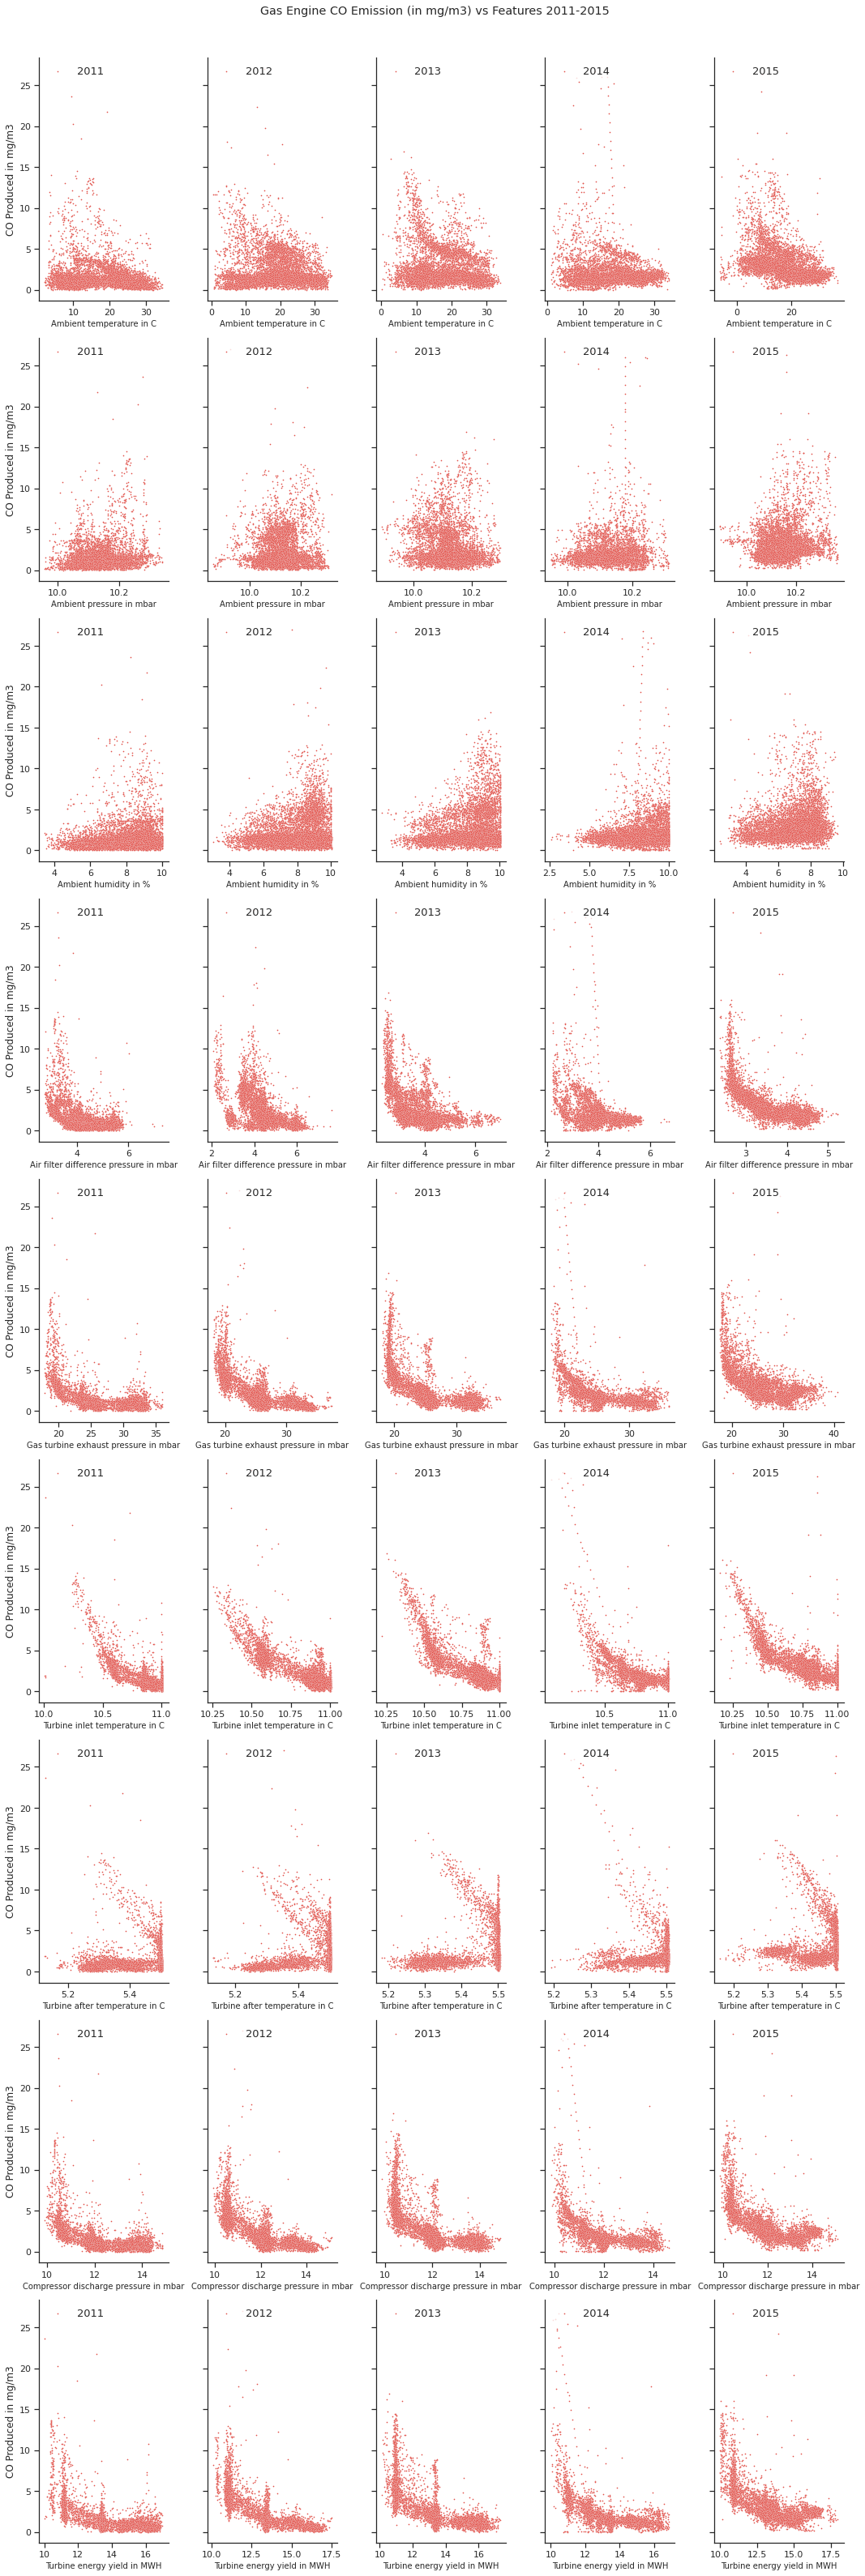

In [48]:
# Plot the Target Column vs Feature Plot by Year

fig, axes = plt.subplots(9,5, figsize=(15,45),sharey = True, sharex = False)
fig.suptitle('Gas Engine CO Emission (in mg/m3) vs Features 2011-2015')
fig.tight_layout(pad=2)
fig.subplots_adjust(top=0.96)
for row,column in enumerate(df[column_info.keys()]):
    for col in range(5):
        year = 2011+col
        sns.scatterplot(ax=axes[row][col], x=df_filtered[df['YEAR'] == year][column],
                        y=df_filtered[df['YEAR'] == year]['CO'], s=3, label=year)
        axes[row][col].set_xlabel(column_info[column],fontsize=10)
        axes[row][col].set_ylabel("CO Produced in mg/m3")
        axes[row][col].legend(loc="upper left", fontsize = 13, facecolor='white', edgecolor='white', borderpad = 0.3) 

plt.show()  

***
#### Write your findings here.
***

<Figure size 432x288 with 0 Axes>

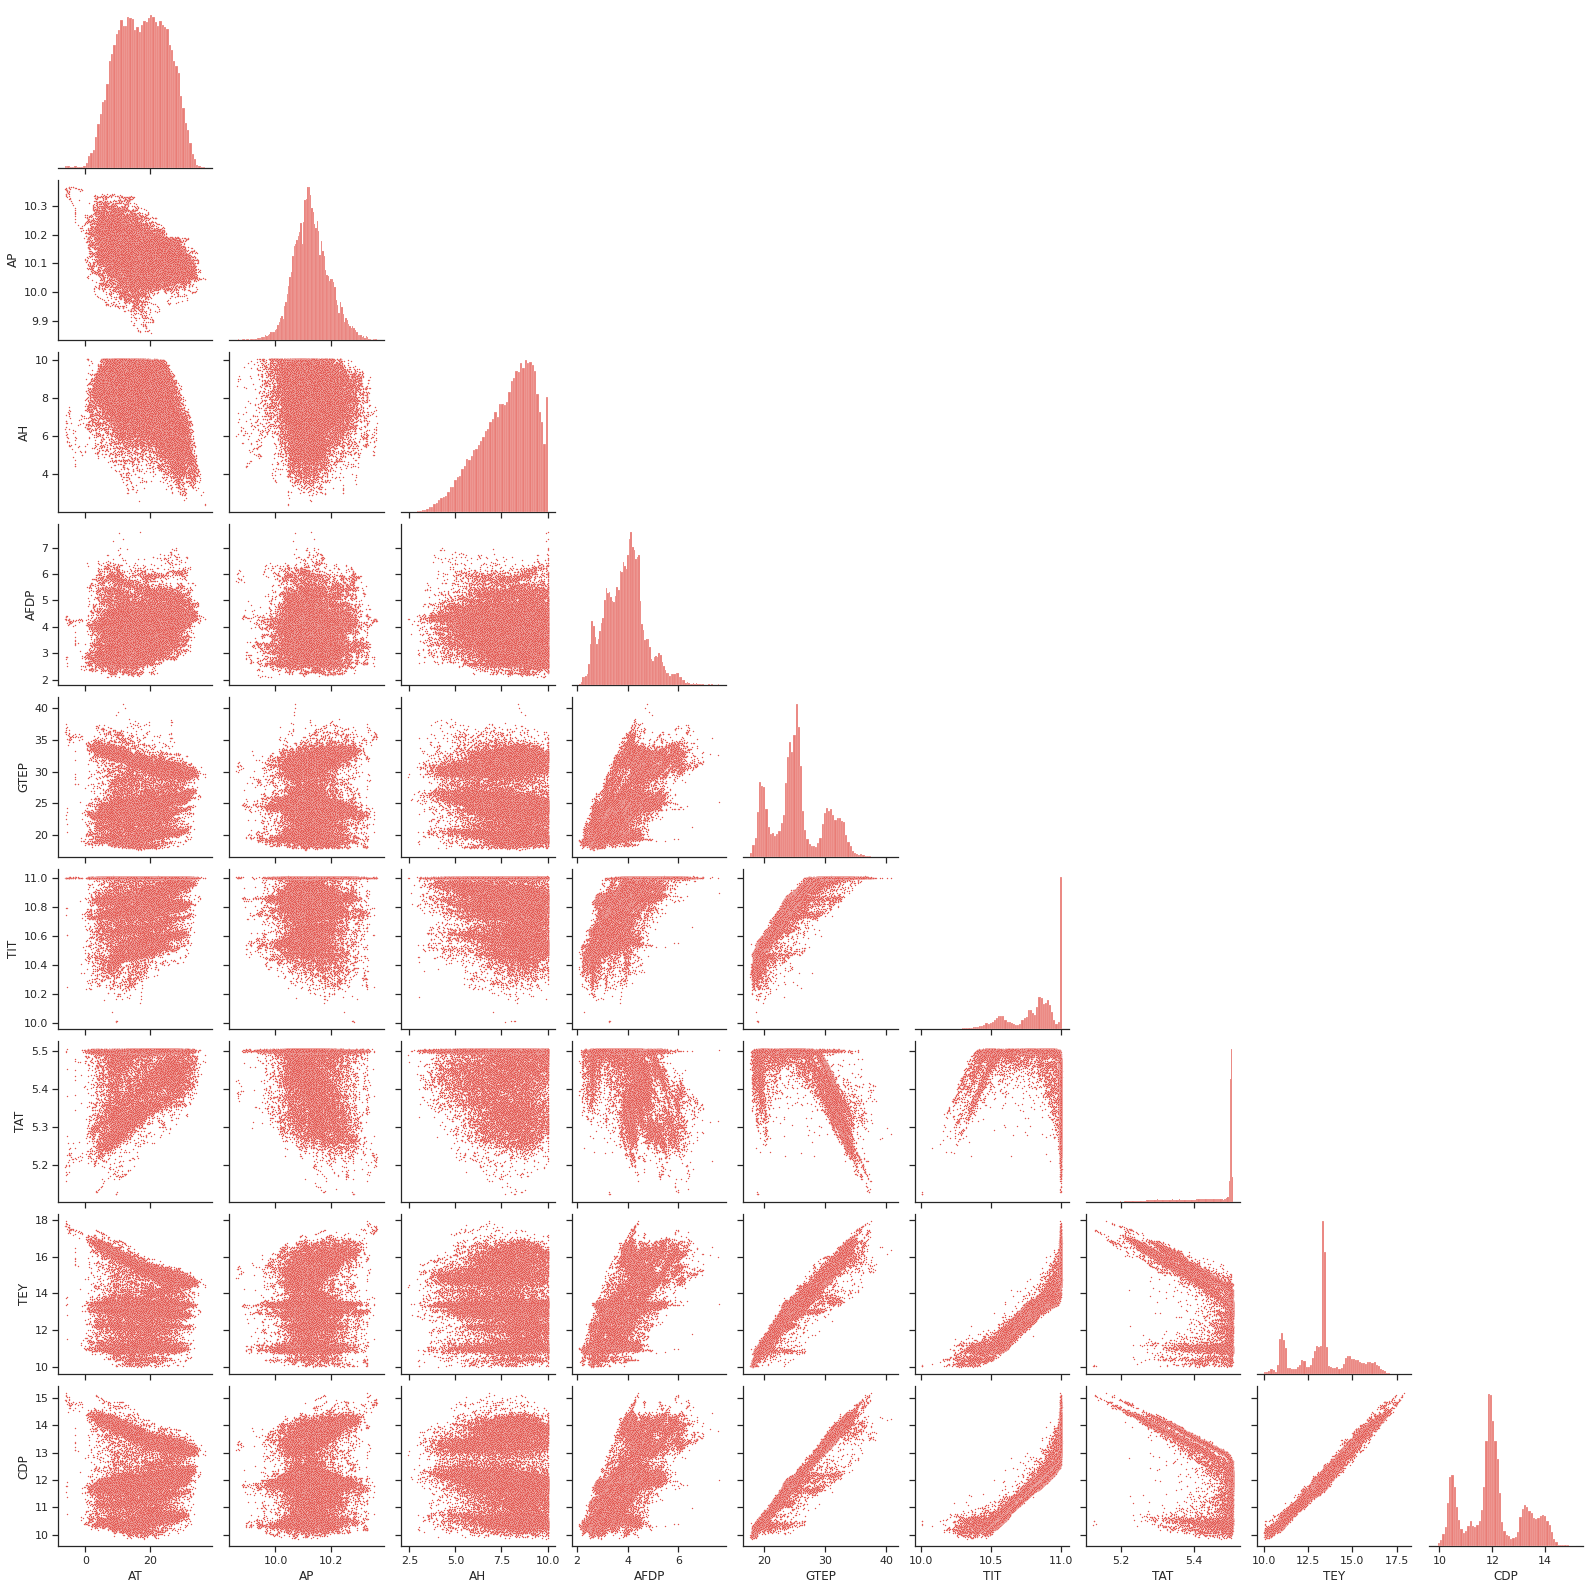

In [52]:
# Plot the Inter-feature interactions
plt.suptitle("Inter-feature interactions")
sns.pairplot(df_filtered.iloc[:,1:-1],plot_kws={"s": 2},corner=True)
plt.show()

***
#### Write your findings here.
***

In [54]:
# Get the Correlation matrix
column_info = "AT : Ambient temperature in C \n AP : Ambient pressure in mbar \n AH : Ambient humidity in % \n AFDP : Air filter difference pressure in mbar \n GTEP : Gas turbine exhaust pressure in mbar\n TIT : Turbine inlet temperature in C \n TAT : Turbine after temperature in C\n CDP : Compressor discharge pressure in mbar\n TEY :T urbine energy yield in MWH \n CO : Carbon Monoxide Emission"

corr = df_filtered.iloc[:,1:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,mask = mask,cmap="Spectral",annot = True, vmax=.3, center=0, linewidths=1, cbar_kws={"shrink": .5})
axes.text(14,9,column_info,bbox={'facecolor': 'white', 'alpha': 0, 'pad': 7}, fontsize=12)
plt.yticks(rotation=0)
plt.show()

In [56]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

In [57]:
# Find index of feature columns with correlation greater than 0.90
high_cor = [column for column in upper.columns if any(upper[column] > 0.90)]
print("Features with rho > {} are {}".format(0.90,high_cor))

Features with rho > 0.9 are ['TEY', 'CDP']


***
#### What is the effect of correlation?
***